# Forecasting AI and ML Job Trends with SARIMA

At this stage, we handle imballances, train various models and evaluate them

## Dependencies

In [27]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm  # Or use tqdm instead of tqdm.notebook

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize

import torch

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate

import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

## Data Loading

In [3]:
filename = "data/c_job_postings_dataset_cleaned.parquet"
data = pd.read_parquet(filename)

In [4]:
print(f"{len(data):,} job postings loaded from {filename}")
data.sample(5)

1,296,381 job postings loaded from data/c_job_postings_dataset_cleaned.parquet


,text,label
698263,sale consultant installer equal one ltd sale c...,0
856099,sap treasury senior managerconsultinglocation ...,0
325215,retail store manager director educational prog...,0
218834,family nurse practitioner physician assistant ...,0
696612,compensation benefit manager manager benefit s...,0


## Handling Class Imballance

In [5]:
class ImbalanceHandler:
    def __init__(self, data, text_column, label_column):
        self.data = data
        self.text_column = text_column
        self.label_column = label_column

        # Vectorize text data and apply SMOTE
        self.vectorizer = TfidfVectorizer(max_features=5000)
        # Reduce majority class to 35% of the dataset
        self.undersample = RandomUnderSampler(sampling_strategy=0.35, random_state=42)
        # Oversample minority class using SMOTE
        self.smote = SMOTE(random_state=42)
        self.pipeline = Pipeline(
            [
                ("tfidf", self.vectorizer),
                ("undersample", self.undersample),
                ("smote", self.smote),
            ]
        )

    def handle_imbalance(self):
        # Extract features and labels
        X = self.data[self.text_column]
        y = self.data[self.label_column]

        # Apply the pipeline
        print("Handling imbalance...")
        for _ in tqdm(range(1), desc="Resampling"):
            X_res, y_res = self.pipeline.fit_resample(X, y)

        # Include the original text and resampled labels
        print("Creating resampled dataset...")
        resampled_data = pd.DataFrame({self.text_column: X.loc[y_res.index], self.label_column: y_res})
        
        print('Completed handling class imbalance')

        return X_res, y_res, resampled_data

In [6]:
def plot_class_distribution(cleaned_data, y_resampled):
    _, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Visualize the class imbalance before handling
    cleaned_data['label'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Class Distribution Before Handling Imbalance')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Frequency')

    # Visualize the class distribution after handling imbalance
    pd.Series(y_resampled).value_counts().plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title('Class Distribution After Handling Imbalance')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

Handling imbalance...


Resampling:   0%|          | 0/1 [00:00<?, ?it/s]

Creating resampled dataset...
Completed handling class imbalance
Original dataset shape: Counter({0: 1274405, 1: 21976})
Resampled dataset shape: Counter({0: 62788, 1: 62788})


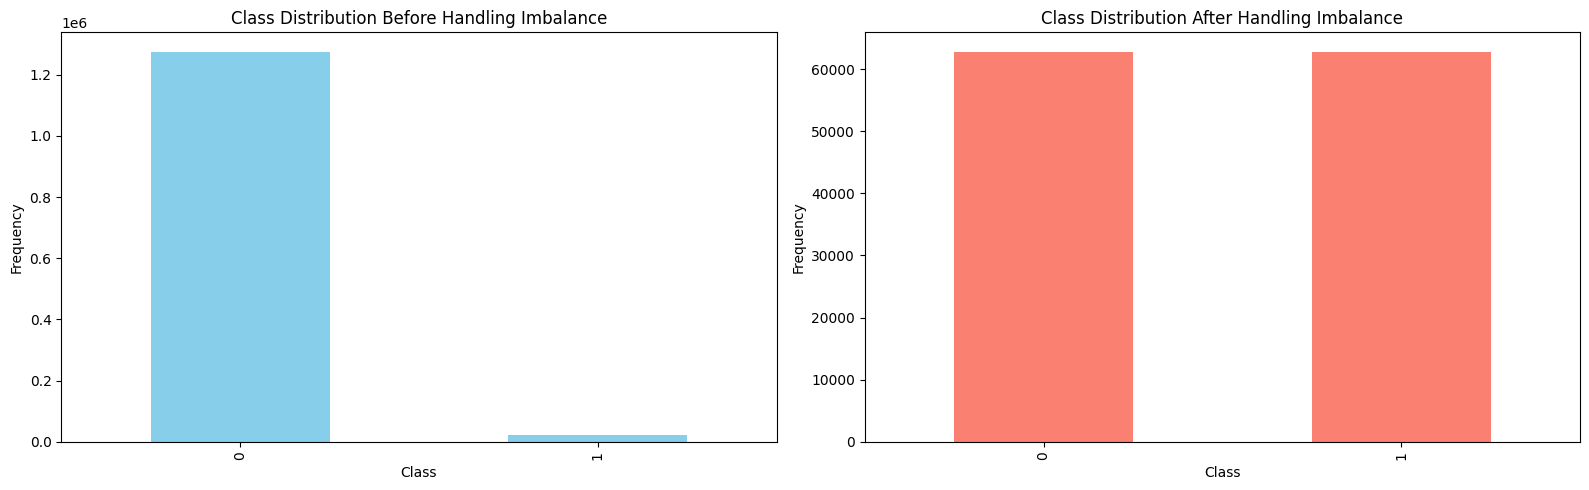

In [7]:
imbalanceHandler = ImbalanceHandler(data, 'text', 'label')
X_res, y_res, resampled_data = imbalanceHandler.handle_imbalance()


# Check the distribution of the new dataset
print(f"Original dataset shape: {Counter(data['label'])}")
print(f"Resampled dataset shape: {Counter(y_res)}")

plot_class_distribution(data, y_res)

## Model Utils

Label encoder

In [8]:
le = preprocessing.LabelEncoder()
le.fit(y_res)
y = le.transform(y_res)

print(f"Classes: {le.classes_}")

Classes: [0 1]


Model performance evaluation

In [18]:
def evaluate_model(y_true, y_pred, y_pred_proba, le):
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot confusion matrix
    disp.plot(cmap='Blues', xticks_rotation=45, ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    # Plot ROC curve
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

## Random Forest Classifier

Split the resampled data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.25, random_state=42
)

Train the model

In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Use the model to make predictions

In [77]:
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15731
           1       0.97      0.99      0.98     15663

    accuracy                           0.98     31394
   macro avg       0.98      0.98      0.98     31394
weighted avg       0.98      0.98      0.98     31394



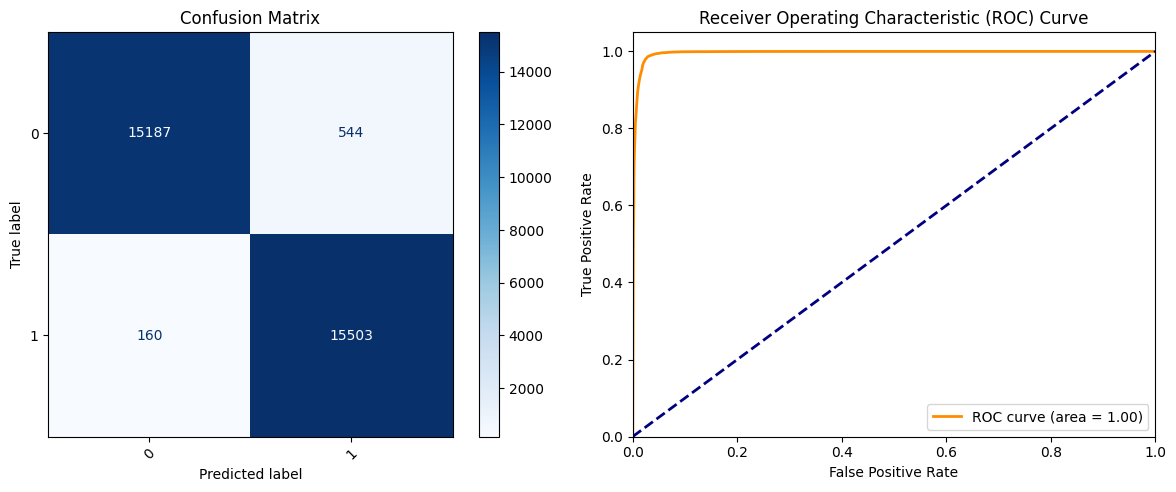

In [78]:
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, le)

**Highlights:**
- At 98% accuracy, the model performs very well overall.
- Balanced Performance: Precision, recall, and F1-scores are all high and similar across both classes.
- Strong Class Distribution Handling: Despite potential class imbalance (similar but not identical support for 0 and 1), the model handles both classes effectively.
- The AUC is approximately 1.00, indicating excellent performance. 
- The curve's shape and position near the top-left corner further emphasize the model's strong predictive power.

## Gradient Boosting Classifier

In [26]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [28]:
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15731
           1       0.97      0.98      0.98     15663

    accuracy                           0.98     31394
   macro avg       0.98      0.98      0.98     31394
weighted avg       0.98      0.98      0.98     31394



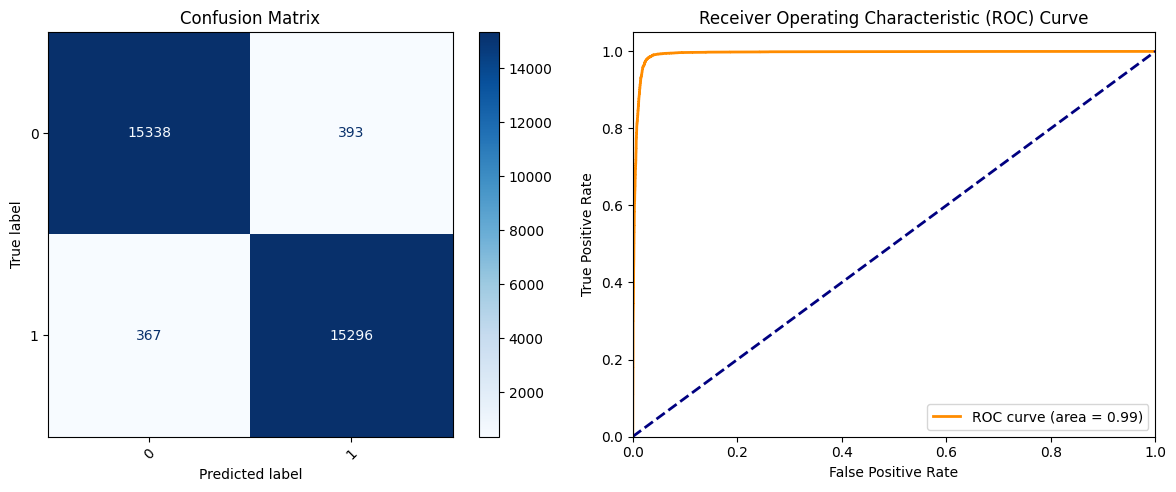

In [30]:
evaluate_model(y_test, y_pred_gb, y_pred_proba_gb, le)

##  Pretrained Tiny BERT Model

In [31]:
model_name = "prajjwal1/bert-tiny"
device = torch.device("cpu")

#### Dataset Preparation

Label handling

In [32]:
le_t = preprocessing.LabelEncoder()
le_t.fit(resampled_data['label'].tolist())
resampled_data['label'] = le.transform(resampled_data['label'].tolist())

Convert to Huggingface Dataset

In [33]:
df_train, df_test = train_test_split(resampled_data, test_size=0.25, random_state=42)

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

train_dataset = train_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

In [34]:
train_dataset.shape, test_dataset.shape

((94182, 3), (31394, 3))

#### Tokenizer

In [35]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/94182 [00:00<?, ? examples/s]

Map:   0%|          | 0/31394 [00:00<?, ? examples/s]

Initialize Model

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)
print(f"Training model on {device}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model on cpu


#### Model Training

In [37]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=2,  # Reduce batch size to fit in memory
    per_device_eval_batch_size=2,
    num_train_epochs=5,  # Adjust epochs for faster completion
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,  # Enable progress bar
    gradient_accumulation_steps=4,  # Simulate larger batch size
    dataloader_num_workers=2  # Optimize dataloader performance
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [39]:
# torch.mps.empty_cache()

trainer.train()
trainer.save_model("ai_ml_job_classiffier")

  0%|          | 0/35316 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6949, 'grad_norm': 7.6225385665893555, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.692105770111084, 'eval_accuracy': 0.516850353570746, 'eval_runtime': 252.3275, 'eval_samples_per_second': 124.418, 'eval_steps_per_second': 62.209, 'epoch': 1.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6925, 'grad_norm': 9.920975685119629, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6946457624435425, 'eval_accuracy': 0.5146843345862266, 'eval_runtime': 256.1381, 'eval_samples_per_second': 122.567, 'eval_steps_per_second': 61.283, 'epoch': 2.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'loss': 0.6892, 'grad_norm': 10.267038345336914, 'learning_rate': 0.0, 'epoch': 3.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

{'eval_loss': 0.6938586831092834, 'eval_accuracy': 0.5160858762820921, 'eval_runtime': 240.8939, 'eval_samples_per_second': 130.323, 'eval_steps_per_second': 65.161, 'epoch': 3.0}
{'train_runtime': 4026.8493, 'train_samples_per_second': 70.166, 'train_steps_per_second': 8.77, 'train_loss': 0.6922044286318524, 'epoch': 3.0}


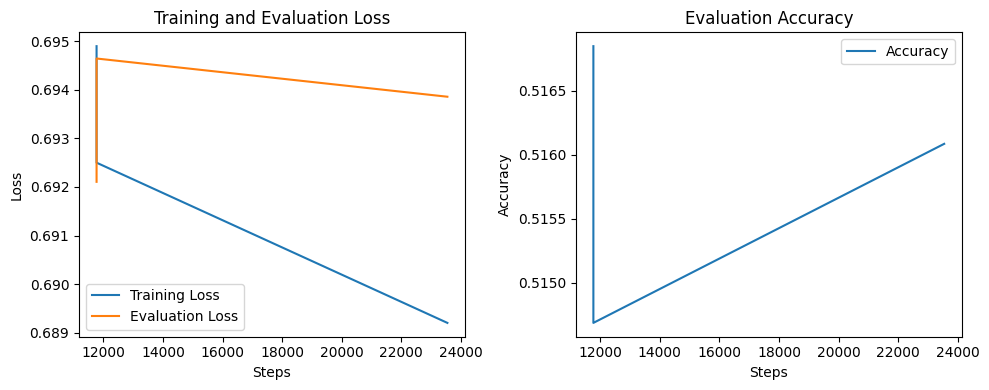

In [76]:
def train_and_plot(trainer):
    # Extract training logs
    training_logs = trainer.state.log_history

    # Extract loss and accuracy
    train_loss = [log['loss'] for log in training_logs if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
    accuracy = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]
    steps = [log['step'] for log in training_logs if 'step' in log]

    # Ensure all lists have the same length
    min_length = min(len(train_loss), len(eval_loss), len(accuracy), len(steps))
    train_loss = train_loss[:min_length]
    eval_loss = eval_loss[:min_length]
    accuracy = accuracy[:min_length]
    steps = steps[:min_length]

    # Plot training loss and accuracy side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot training loss
    ax1.plot(steps, train_loss, label='Training Loss')
    ax1.plot(steps, eval_loss, label='Evaluation Loss')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Evaluation Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(steps, accuracy, label='Accuracy')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Evaluation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

train_and_plot(trainer)

#### Model Evaluation

Evaluate on the training set

In [ ]:
preds_train = trainer.predict(tokenized_train)

In [ ]:
preds_train = np.argmax(preds_train[:3][0],axis=1)
GT = df_train['label'].tolist()

print("Training metrics")
print(classification_report(GT, preds_train))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/47091 [00:00<?, ?it/s]

Training metrics
              precision    recall  f1-score   support

           0       0.57      0.43      0.49     47057
           1       0.54      0.68      0.60     47125

    accuracy                           0.55     94182
   macro avg       0.56      0.55      0.55     94182
weighted avg       0.56      0.55      0.55     94182



In [ ]:
preds_test = trainer.predict(tokenized_test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/15697 [00:00<?, ?it/s]

AxisError: axis 1 is out of bounds for array of dimension 1

              precision    recall  f1-score   support

           0       0.52      0.39      0.45     15731
           1       0.51      0.64      0.57     15663

    accuracy                           0.52     31394
   macro avg       0.52      0.52      0.51     31394
weighted avg       0.52      0.52      0.51     31394



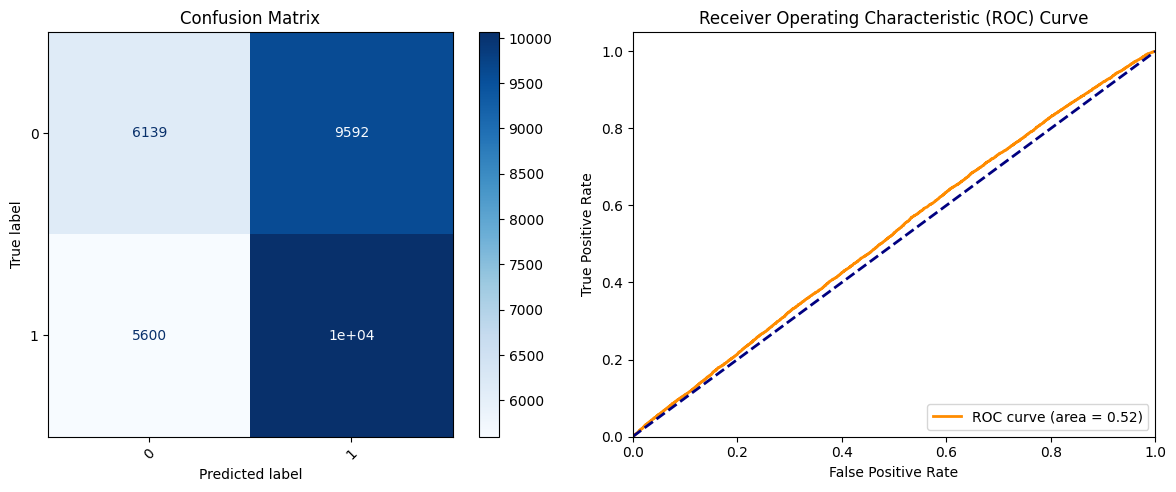

In [93]:
y_pred_bert = np.argmax(preds_test.predictions, axis=1)
y_true_bert = tokenized_test['label']

len(y_pred_bert), len(y_true_bert)

evaluate_model(y_true_bert, y_pred_bert, preds_test.predictions[:, 1], le_t)